In [1]:
import numpy as np
from datasets import load_dataset
from datasets import concatenate_datasets
from collections import Counter

#loading the dataset
ds = load_dataset("wellCh4n/tomato-leaf-disease-image")


original_labels = sorted(list(set(ds["train"]["label"])))
label_mapping = {old: new for new, old in enumerate(original_labels)}

def remap_label(example):
    example["label"] = label_mapping[example["label"]]
    return example

ds = ds.map(remap_label)

#Combining the 2 splits into one dataset to redistribute
ds_full = concatenate_datasets([ds["train"], ds["validation"]])

#Data split into 70/15/15
train_test = ds_full.train_test_split(test_size=0.3, stratify_by_column="label", seed=42)
dev_test = train_test["test"].train_test_split(test_size=0.5,stratify_by_column="label", seed=42)

ds_split = {
    "train": train_test["train"],
    "validation": dev_test["train"],
    "test": dev_test["test"]
}


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/56.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14218 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3569 [00:00<?, ? examples/s]

Map:   0%|          | 0/14218 [00:00<?, ? examples/s]

Map:   0%|          | 0/3569 [00:00<?, ? examples/s]

<h3>Displaying the Class Distribution</h3>

In [2]:
def print_distribution(name, dataset):
    labels = dataset["label"]
    counts = Counter(labels)
    print(f"\n{name} set distribution:")
    for label, count in sorted(counts.items()):
        print(f"  Class {label}: {count} samples ({count/len(labels) * 100:.2f}%)")
    print(f"  Total: {len(labels)} samples")

print_distribution("Train", ds_split["train"])
print_distribution("Validation", ds_split["validation"])
print_distribution("Test", ds_split["test"])



Train set distribution:
  Class 0: 1114 samples (8.95%)
  Class 1: 666 samples (5.35%)
  Class 2: 983 samples (7.90%)
  Class 3: 1336 samples (10.73%)
  Class 4: 700 samples (5.62%)
  Class 5: 1489 samples (11.96%)
  Class 6: 1239 samples (9.95%)
  Class 7: 3750 samples (30.12%)
  Class 8: 1173 samples (9.42%)
  Total: 12450 samples

Validation set distribution:
  Class 0: 239 samples (8.96%)
  Class 1: 143 samples (5.36%)
  Class 2: 211 samples (7.91%)
  Class 3: 286 samples (10.72%)
  Class 4: 150 samples (5.62%)
  Class 5: 319 samples (11.96%)
  Class 6: 266 samples (9.97%)
  Class 7: 803 samples (30.10%)
  Class 8: 251 samples (9.41%)
  Total: 2668 samples

Test set distribution:
  Class 0: 238 samples (8.92%)
  Class 1: 143 samples (5.36%)
  Class 2: 210 samples (7.87%)
  Class 3: 287 samples (10.75%)
  Class 4: 150 samples (5.62%)
  Class 5: 319 samples (11.95%)
  Class 6: 266 samples (9.97%)
  Class 7: 804 samples (30.12%)
  Class 8: 252 samples (9.44%)
  Total: 2669 samples


<h3>Extracting features for Machine Learning</h3>

In [3]:
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray
from skimage.transform import resize

RESIZE_SHAPE = (128, 128)

# HOG parameters
HOG_ORIENTATIONS = 9
HOG_PIXELS_PER_CELL = (8, 8)
HOG_CELLS_PER_BLOCK = (2, 2)

# LBP parameters
LBP_RADIUS = 3
LBP_POINTS = 8 * LBP_RADIUS

def extract_features(image):

    img_resized = resize(image, RESIZE_SHAPE, anti_aliasing=True)
    img_resized = (img_resized * 255).astype(np.uint8)

   #HOG
    gray_float = rgb2gray(img_resized)
    gray = (gray_float * 255).astype(np.uint8) 
    
    hog_features = hog(
        gray,
        orientations=HOG_ORIENTATIONS,
        pixels_per_cell=HOG_PIXELS_PER_CELL,
        cells_per_block=HOG_CELLS_PER_BLOCK,
        visualize=False,
    )

    #LBP
    lbp = local_binary_pattern(gray, LBP_POINTS, LBP_RADIUS, method="uniform")

    lbp_hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, LBP_POINTS + 3),
        range=(0, LBP_POINTS + 2)
    )
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7) 

    #Color Histogram
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_RGB2HSV)

    hsv_hist = []
    hist_sizes = [180, 256, 256]
    ranges = [(0, 180), (0, 256), (0, 256)]

    for ch, (bins, rng) in enumerate(zip(hist_sizes, ranges)):
        hist = cv2.calcHist([hsv], [ch], None, [bins], rng)
        hsv_hist.extend(hist.flatten())

    hsv_hist = np.array(hsv_hist, dtype=np.float32)

    hsv_hist /= (np.sum(hsv_hist) + 1e-7)

    final_vector = np.concatenate([
        hog_features,
        lbp_hist,
        hsv_hist
    ])

    return final_vector

In [4]:
from tqdm import tqdm

def process_split(dataset_split):
    X = []
    y = []

    for item in tqdm(dataset_split, desc="Extracting features", ncols=100):
        img = np.array(item["image"].convert("RGB"))

        features = extract_features(img)

        X.append(features)
        y.append(item["label"])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int64)

    return X, y


X_train, y_train = process_split(ds_split["train"])
print("Train features shape:", X_train.shape)

X_validation, y_validation = process_split(ds_split["validation"])
print("Dev features shape:", X_validation.shape)

X_test, y_test = process_split(ds_split["test"])
print("Test features shape:", X_test.shape)


Extracting features: 100%|████████████████████████████████████| 12450/12450 [04:07<00:00, 50.21it/s]


Train features shape: (12450, 8818)


Extracting features: 100%|██████████████████████████████████████| 2668/2668 [00:52<00:00, 50.34it/s]


Dev features shape: (2668, 8818)


Extracting features: 100%|██████████████████████████████████████| 2669/2669 [00:53<00:00, 50.26it/s]

Test features shape: (2669, 8818)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

<h3>Training Machine Learning Models</h3>

In [6]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

<h4>Random Forest</h4>

In [7]:
def evaluate(model, Xv, yv):
    preds = model.predict(Xv)
    return accuracy_score(yv, preds)

rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [10, 20],
    "min_samples_split": [2, 5],
}

best_rf_acc = -1
best_rf_params = None

for params in tqdm(ParameterGrid(rf_param_grid)):
    rf = RandomForestClassifier(
        class_weight='balanced',
        random_state=34,
        **params
    )
    rf.fit(X_train_scaled, y_train)
    acc = evaluate(rf, X_validation_scaled, y_validation)

    if acc > best_rf_acc:
        best_rf_acc = acc
        best_rf_params = params

print("Best RF Params:", best_rf_params)
print("Validation Accuracy:", best_rf_acc)

#Retraining
rf_final = RandomForestClassifier(
    class_weight='balanced',
    random_state=34,
    **best_rf_params
)
rf_final.fit(
    np.concatenate([X_train_scaled, X_validation_scaled]),
    np.concatenate([y_train, y_validation])
)

100%|██████████| 8/8 [09:34<00:00, 71.80s/it]


Best RF Params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Validation Accuracy: 0.926911544227886


RandomForestClassifier(class_weight='balanced', max_depth=20, random_state=34)

<h4>SVM</h4>

In [8]:

svm_final = SVC(
    class_weight="balanced",
    random_state=34,
    C=10,
    gamma="scale",
    kernel="rbf"
)

svm_final.fit(
    np.concatenate([X_train_scaled, X_validation_scaled]),
    np.concatenate([y_train, y_validation])
)

SVC(C=10, class_weight='balanced', random_state=34)

<h4>K-Nearest Neighbor (KNN)</h4>

In [9]:
knn_param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}

best_knn_acc = -1
best_knn_params = None

for params in tqdm(ParameterGrid(knn_param_grid)):
    knn = KNeighborsClassifier(**params)
    knn.fit(X_train_scaled, y_train)
    acc = evaluate(knn, X_validation_scaled, y_validation)

    if acc > best_knn_acc:
        best_knn_acc = acc
        best_knn_params = params

print("Best KNN Params:", best_knn_params)
print("Validation Accuracy:", best_knn_acc)

# Retraining
knn_final = KNeighborsClassifier(**best_knn_params)
knn_final.fit(
    np.concatenate([X_train_scaled, X_validation_scaled]),
    np.concatenate([y_train, y_validation])
)


100%|██████████| 16/16 [30:51<00:00, 115.74s/it]


Best KNN Params: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Validation Accuracy: 0.7706146926536732


KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

<h3>Testing the Models</h3>

In [10]:
def final_results(model, Xtest, ytest, name):
    preds = model.predict(Xtest)
    print(f"{name}:")
    print(f"Accuracy: {(accuracy_score(ytest, preds) * 100):.2f}%")
    print("\nClassification Report:\n", classification_report(ytest, preds))
    cm = confusion_matrix(ytest, preds)

    # Plot Confusion Matrix
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

Random Forest:
Accuracy: 91.79%

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       238
           1       0.93      0.90      0.91       143
           2       0.91      0.89      0.90       210
           3       0.91      0.89      0.90       287
           4       0.94      0.73      0.82       150
           5       0.92      0.88      0.90       319
           6       0.94      0.95      0.94       266
           7       0.90      0.98      0.94       804
           8       0.88      0.85      0.87       252

    accuracy                           0.92      2669
   macro avg       0.92      0.89      0.91      2669
weighted avg       0.92      0.92      0.92      2669



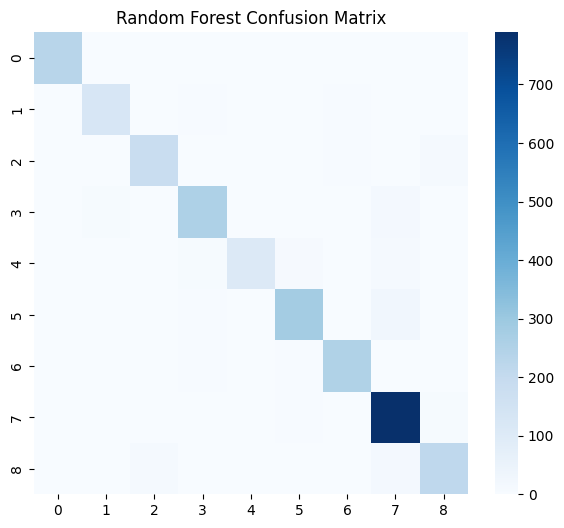

SVM:
Accuracy: 91.08%

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       238
           1       0.94      0.85      0.89       143
           2       0.88      0.87      0.87       210
           3       0.81      0.85      0.83       287
           4       0.76      0.69      0.72       150
           5       0.94      0.92      0.93       319
           6       0.92      0.90      0.91       266
           7       0.95      0.98      0.96       804
           8       0.90      0.90      0.90       252

    accuracy                           0.91      2669
   macro avg       0.90      0.88      0.89      2669
weighted avg       0.91      0.91      0.91      2669



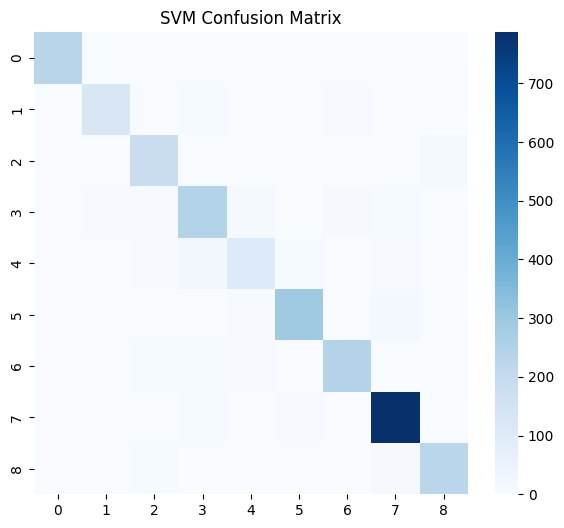

KNN:
Accuracy: 77.44%

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.97      0.68       238
           1       0.77      0.70      0.73       143
           2       0.61      0.42      0.50       210
           3       0.92      0.55      0.69       287
           4       0.79      0.21      0.33       150
           5       0.83      0.90      0.87       319
           6       0.83      0.66      0.74       266
           7       0.94      0.95      0.94       804
           8       0.63      0.92      0.75       252

    accuracy                           0.77      2669
   macro avg       0.76      0.70      0.69      2669
weighted avg       0.80      0.77      0.76      2669



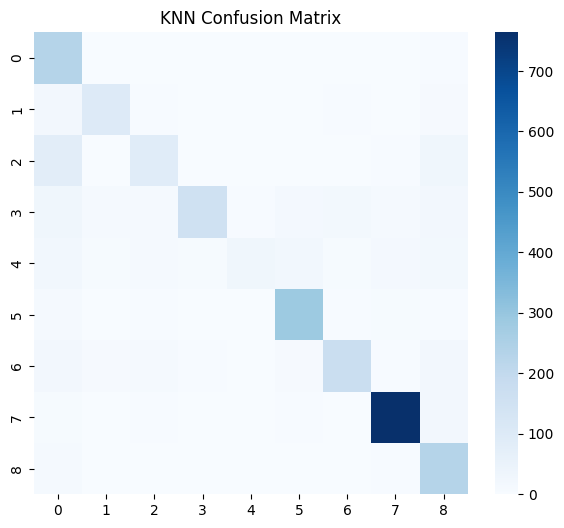

In [11]:
final_results(rf_final,  X_test_scaled, y_test, "Random Forest")
final_results(svm_final, X_test_scaled, y_test, "SVM")
final_results(knn_final, X_test_scaled, y_test, "KNN")


<h3>Processing Images for Deep Learning</h3>

In [12]:
import tensorflow as tf

def hf_to_tfds(hf_split):
    def gen():
        for item in hf_split:
            img = item["image"]
            img = tf.keras.preprocessing.image.img_to_array(img)
            label = item["label"]
            yield img, label

    return tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float32, tf.int32),
        output_shapes=((None, None, 3), ())
    )

train_ds_raw = hf_to_tfds(ds_split["train"])
val_ds_raw   = hf_to_tfds(ds_split["validation"])
test_ds_raw  = hf_to_tfds(ds_split["test"])


2025-11-21 11:26:59.677357: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763724419.948187      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763724420.021002      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


I0000 00:00:1763724435.600548      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763724435.601239      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [13]:
IMG_SIZE = 128

# Resize images and prepare for resnet
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255
    return image, label

# Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.15),
], name="data_augmentation")

def augment(image, label):
    return data_augmentation(image), label

BATCH_SIZE = 32

# Train dataset
train_ds = (
    train_ds_raw
    .shuffle(2000)
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Validation dataset
val_ds = (
    val_ds_raw
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Test dataset
test_ds = (
    test_ds_raw
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)


In [14]:
# Calculating the class weights
def compute_class_weights(labels):
    counts = Counter(labels)
    total = sum(counts.values())

    class_weights = {
        cls: total / (len(counts) * count)
        for cls, count in counts.items()
    }
    return class_weights

labels_list = [item["label"] for item in ds_split["train"]]
class_weights = compute_class_weights(labels_list)

<h3>Building and training the CNN</h3>

In [15]:
def create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=9):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.summary()


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_epoch.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)


EPOCHS = 50

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[early_stop, checkpoint]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 456,521 (1.74 MB)

 Trainable params: 456,521 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


I0000 00:00:1763724452.985825      91 service.cc:148] XLA service 0x7809d8003010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763724452.986856      91 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1763724452.986880      91 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1763724453.796175      91 cuda_dnn.cc:529] Loaded cuDNN version 90300


      9/Unknown 11s 21ms/step - accuracy: 0.0511 - loss: 2.2753

I0000 00:00:1763724458.017705      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    390/Unknown 45s 89ms/step - accuracy: 0.2227 - loss: 2.0768

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 1.83747, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 51s 103ms/step - accuracy: 0.2230 - loss: 2.0765 - val_accuracy: 0.4160 - val_loss: 1.8375
Epoch 2/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5022 - loss: 1.5203
Epoch 2: val_loss improved from 1.83747 to 0.99609, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.5024 - loss: 1.5197 - val_accuracy: 0.6747 - val_loss: 0.9961
Epoch 3/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6404 - loss: 1.1582
Epoch 3: val_loss improved from 0.99609 to 0.63531, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.6405 - loss: 1.1578 - val_accuracy: 0.7744 - val_loss: 0.6353
Epoch 4/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7296 - loss: 0.9116
Epoch 4: val_loss improved from 0.63531 to 0.55309, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.7297 - loss: 0.9111 - val_accuracy: 0.8126 - val_loss: 0.5531
Epoch 5/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7734 - loss: 0.7294
Epoch 5: val_loss did not improve from 0.55309
390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.7735 - loss: 0.7292 - val_accuracy: 0.7927 - val_loss: 0.5741
Epoch 6/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7990 - loss: 0.6461
Epoch 6: val_loss improved from 0.55309 to 0.45863, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.7991 - loss: 0.6458 - val_accuracy: 0.8321 - val_loss: 0.4586
Epoch 7/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8192 - loss: 0.5686
Epoch 7: val_loss improved from 0.45863 to 0.37445, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.8193 - loss: 0.5684 - val_accuracy: 0.8729 - val_loss: 0.3744
Epoch 8/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8522 - loss: 0.4808
Epoch 8: val_loss did not improve from 0.37445
390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.8523 - loss: 0.4807 - val_accuracy: 0.8519 - val_loss: 0.3924
Epoch 9/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8522 - loss: 0.4755
Epoch 9: val_loss improved from 0.37445 to 0.33671, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.8522 - loss: 0.4753 - val_accuracy: 0.8876 - val_loss: 0.3367
Epoch 10/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8669 - loss: 0.4127
Epoch 10: val_loss improved from 0.33671 to 0.21023, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.8670 - loss: 0.4126 - val_accuracy: 0.9273 - val_loss: 0.2102
Epoch 11/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8934 - loss: 0.3392
Epoch 11: val_loss did not improve from 0.21023
390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.8934 - loss: 0.3393 - val_accuracy: 0.8988 - val_loss: 0.2840
Epoch 12/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8864 - loss: 0.3440
Epoch 12: val_loss did not improve from 0.21023
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.8864 - loss: 0.3440 - val_accuracy: 0.8707 - val_loss: 0.3561
Epoch 13/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9020 - loss: 0.3158
Epoch 13: val_loss did not improve from 0.21023
390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.9020 - loss: 0.3157 - val_accuracy: 0.9168 - val_loss: 0.2220
Epoch 14/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9060 - loss: 0.3176
Epoch 14: val_loss improved 

390/390 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.9060 - loss: 0.3175 - val_accuracy: 0.9299 - val_loss: 0.2059
Epoch 15/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.8942 - loss: 0.3434
Epoch 15: val_loss improved from 0.20592 to 0.16685, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.8943 - loss: 0.3433 - val_accuracy: 0.9404 - val_loss: 0.1669
Epoch 16/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9199 - loss: 0.2633
Epoch 16: val_loss improved from 0.16685 to 0.13454, saving model to best_epoch.h5


390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.9200 - loss: 0.2633 - val_accuracy: 0.9565 - val_loss: 0.1345
Epoch 17/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9115 - loss: 0.2727
Epoch 17: val_loss did not improve from 0.13454
390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 93ms/step - accuracy: 0.9115 - loss: 0.2727 - val_accuracy: 0.9520 - val_loss: 0.1412
Epoch 18/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9281 - loss: 0.2301
Epoch 18: val_loss did not improve from 0.13454
390/390 ━━━━━━━━━━━━━━━━━━━━ 39s 92ms/step - accuracy: 0.9281 - loss: 0.2301 - val_accuracy: 0.8771 - val_loss: 0.3170
Epoch 19/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9173 - loss: 0.2352
Epoch 19: val_loss did not improve from 0.13454
390/390 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.9174 - loss: 0.2351 - val_accuracy: 0.9359 - val_loss: 0.1789
Epoch 20/50
389/390 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9264 - loss: 0.2297
Epoch 20: val_loss did not i

<h3>Testing the CNN</h3>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

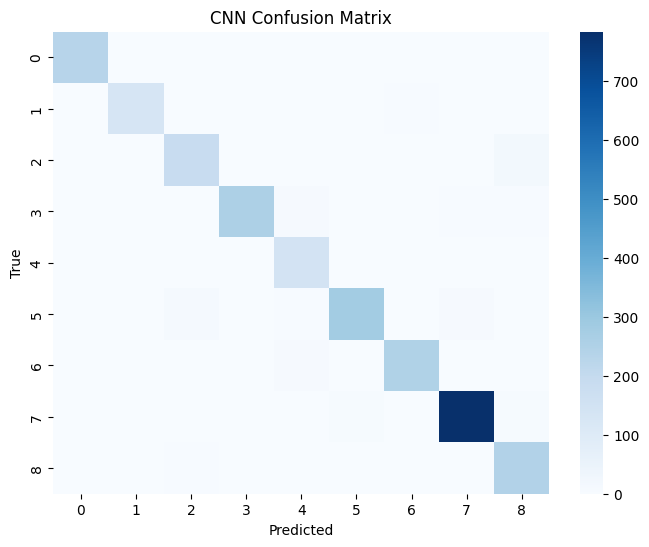

In [16]:

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {acc * 100:.2f}%")

print("\nCNN Classification Report:")
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
